In [1]:
import joblib
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import random
import time
import datetime
from sklearn.metrics import r2_score
import numpy as np
from tqdm.notebook import tqdm


sys.path.append("../lib/")
from MoleculeRegressor import MoleculeRegressor,FP
from rbm_util import train_rbm


sys.path.append("../REINVENT/lib/")
from reinvent_wrapper import run_reinvent,run_reinvent_parallel
from anneal_util import r_qubo_sampling,random_state_sampling


RDKit WARNING: [10:03:35] Enabling RDKit 2019.09.3 jupyter extensions


# Regression
    - Calculate slope for a linear regression model

In [2]:
def get_model(cond):
    df = pd.read_csv(cond["database_path"])
    df = df[[cond["smiles_column"], cond["target_param_name"]]]
    df = df.dropna()

    # delete broken smiles
    _, available_index = FP.calc_fingerprint(df[cond["smiles_column"]].values)
    df = df[available_index]

    model = MoleculeRegressor()
    X = df[cond["smiles_column"]]
    y = np.array(df[cond["target_param_name"]])
    model.fit(X, y)
    p_y = model.predict(X)

    plt.figure(figsize=(4, 4))
    plt.scatter(y, p_y, s=3)

    return model

# RBM
    - Calculate user-preference potential

In [3]:
def run_rbm(start_smiles):
    fp_list,_=FP.calc_fingerprint(start_smiles)
    joblib.dump(fp_list,"data/fp.bin")
    batch_size=1

    all_dim=1024*2
    fp_dim=len(fp_list[0])

    while all_dim <= fp_dim:
        all_dim=all_dim*2

    print("RBM dimension:", all_dim)
    plt.figure()
    _=train_rbm(fp_path="data/fp.bin",
                        out_path="data/rbm_J.bin",
                        batch_size= batch_size,
                        all_units=all_dim,
                        use_gpu=False,
                        epochs = 300,
                        k=3,
                        check_reconstruction=3)


# anneal & DRL

In [4]:
def auto_search(model,save_path):
    #set qubo
    rbm_qubo=joblib.load("data/rbm_J.bin")
    model_qubo=model.coef_

    for r in [2**i for i in range(-4,5,1)]:
        
        print(r)
        result_path=save_path+"/"+str(r)+".bin"
        if os.path.exists(result_path):
            print("already done! skipped")
            continue

        #anneal and drl
        print("start anneal")

        state_list,eg_list,c_list=r_qubo_sampling(r,rbm_qubo,model_qubo)          


        sel_id_list=random_state_sampling(state_list,eg_list,n_sampling=cond["sample_num"])
        sel_fp_list=(np.array(state_list)[sel_id_list])
        sel_fp_list=list(sel_fp_list[:,:512])
    
        
        print("start DQN")
        integ_df=run_reinvent_parallel(sel_fp_list, 
                                       rein_dir='../REINVENT/',
                                       original_dir='../4_compound_extraction/',
                                       n_parallel=cond["sample_num"],
                                       gpu_num=2)

        #dump
        result_dict={}
        result_dict["r"]=r
        result_dict["anneal_result"]=state_list,eg_list,c_list
        result_dict["sel_fp_list"]=sel_fp_list
        result_dict["rbm_qubo"]=rbm_qubo
        result_dict["time"]=time.strftime("%Y-%m-%d-%H_%M_%S", time.localtime())
        result_dict["df"]=integ_df
        #joblib.dump(result_dict,result_path,compress=9)
        return result_dict

In [52]:
#auto_search
cond={}
cond["type"]="anneal_results/"
cond["smiles_column"]="SMILES"
cond["start_smiles"]=["Cc1ccccc1","FC(F)(F)F"]
cond["target_param_name"]="MolLogP"
cond["database_path"]="../database/BradleyDoublePlusGoodMeltingPointDataset_logP.csv"
cond["sample_num"]=4

cond["start_smiles"]=["Cc1ccccc1","FC(F)(F)F"]

#["Cc1ccccc1"],
#["Cc1ccccc1","FC(F)(F)F","O=C(O)C"],

target_param_list="MolLogP"
#"TPSA"


/home/user/anaconda3/envs/da37/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


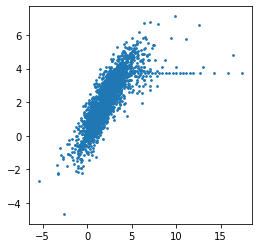

In [50]:
#regression
model=get_model(cond)

In [53]:
#rbm
#run_rbm(cond["start_smiles"])

# Solution sampling and molecule generation
- Solutions are sampled by MCMC in this demo code
- Since MCMC could not reach smaller energy solutions and their hyperparameters were not optimized, the sampled chemicals are quite different from the ones in the paper.

In [54]:
rbm_qubo=joblib.load("data/rbm_J.bin")
model_qubo=model.coef_

#sample minimums
r=1
state_list,eg_list,c_list=r_qubo_sampling(r,rbm_qubo,model_qubo)       
        

100%|██████████| 10000000/10000000 [00:19<00:00, 515124.84it/s]


In [55]:
sel_id_list=random_state_sampling(state_list,eg_list,n_sampling=cond["sample_num"])
sel_fp_list=(np.array(state_list,dtype=int)[sel_id_list])
sel_fp_list=list(sel_fp_list[:,:512])

In [56]:
#drl
integ_df=run_reinvent_parallel(sel_fp_list, 
                               rein_dir='../REINVENT/',
                               original_dir='../4_compound_extraction/',
                               n_parallel=cond["sample_num"],
                               gpu_num=2)

gpus attributed:  [0, 0, 1, 1]


In [59]:
integ_df

,SMILES,Score,PriorLogP
0,Nc1nn(S(=O)(=O)c2cc(Cl)ccc2Cl)c2c1C1C(=NO)C1N2...,0.89,-74.90
1,CC1(F)c2nc(S(C)(=O)=O)sc2C(O)(CO)S(=O)(=O)n2nc...,0.89,-51.09
2,CN1C(=O)C(O)(c2cn(S(C)(=O)=O)s2)C(=O)c2c1noc2S...,0.88,-83.30
3,Cn1c2c(s1)S(=O)(C1=NNNc3ncnc1c32)CC[N+](C)(C)C...,0.88,-59.34
4,CSN(C)P(C=O)OP(=O)(O)PP(=O)(O)c1nonc1N1C(=O)C(...,0.88,-72.66
0,CC([Y])(C[Y])c1noc2c1N(S(C)(C)c1cc(Br)[nH]c1Cl...,0.89,-87.32
1,CC(=N)SC(CO[Si](F)([Y])O[Y])c1noc2c1C(OS(=O)(=...,0.89,-121.70
2,O=C1c2ccsc2C2(O)N1CN(S1(Cl)=NC1)S2(=O)N1CCOCC1,0.88,-67.93
3,Cc1n[nH]c2c1-c1nocc1C(=O)N2CCSCC1=Nc2sc(Cl)nc2...,0.88,-84.39
4,CCCCC(C[Y])N1CCCOc2nc(Br)sc2S1([Y])SOS(=O)(=O)...,0.87,-121.66


In [60]:
integ_df["SMILES"].values

array(['Nc1nn(S(=O)(=O)c2cc(Cl)ccc2Cl)c2c1C1C(=NO)C1N2C(=O)N1CC2(C1)CN(c1nccs1)CC2',
       'CC1(F)c2nc(S(C)(=O)=O)sc2C(O)(CO)S(=O)(=O)n2nccc21',
       'CN1C(=O)C(O)(c2cn(S(C)(=O)=O)s2)C(=O)c2c1noc2SSSS[Si](=O)(=O)S(=O)(=O)c1sccc1C=NO',
       'Cn1c2c(s1)S(=O)(C1=NNNc3ncnc1c32)CC[N+](C)(C)CC[Si](C)([Y])O[Y]',
       'CSN(C)P(C=O)OP(=O)(O)PP(=O)(O)c1nonc1N1C(=O)C(C)(C)c2sccc21',
       'CC([Y])(C[Y])c1noc2c1N(S(C)(C)c1cc(Br)[nH]c1Cl)C(Cl)=C(N)C(Cl)=S2=NC(C)(Cl)Cl',
       'CC(=N)SC(CO[Si](F)([Y])O[Y])c1noc2c1C(OS(=O)(=O)O)CSC(C[Si](C)(C)O[Y])S2([O-])=Nc1nsc(S(N)(=O)=O)c1Cl',
       'O=C1c2ccsc2C2(O)N1CN(S1(Cl)=NC1)S2(=O)N1CCOCC1',
       'Cc1n[nH]c2c1-c1nocc1C(=O)N2CCSCC1=Nc2sc(Cl)nc2C2SCC1N2C',
       'CCCCC(C[Y])N1CCCOc2nc(Br)sc2S1([Y])SOS(=O)(=O)Oc1n[nH]c2c1C(C[Si](C)(C)[Si](C)([Y])O[Y])Oc1ccccc1C2=O',
       'CC1(C)c2onc(OC[Si](C)([Y])O[Y])c2[SH](C)(F)(F)C(F)(F)C(F)(F)N1C#CC=NC1Nc2ncnn2NN[SH]1',
       'CC1(C)c2ccsc2[SH](C)(C)N1OP(=O)(O)Nc1nc2c(ncn2CCC[Si](C)([Y])O[Y])cc1C#CC1(C)CC